In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# **Code to simulate short rate from vasicek and calc noisy yields**

In [ ]:
def simulate_vasicek_data(n_steps,dt, kappa, theta, sigma, r0, maturities, noise_std):
    maturities.reshape(-1,1)
    # Simulate short rate path
    r = np.zeros(n_steps)
    r[0] = r0

    # Generate short rate path
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = kappa * (theta - r[t-1]) * dt + sigma * dW
        r[t] = r[t-1] + dr

    # Generate clean yields
    n_maturities = len(maturities)
    yields = np.zeros((n_maturities,n_steps))

    # Compute bond pricing coefficients 8x1 matrices
    B_tau = (1 - np.exp(-kappa * maturities)) / kappa
    A_tau = (B_tau - maturities) * (theta - sigma**2/(2*kappa**2)) - (sigma**2 * B_tau**2) / (4*kappa)

    # Generate yields for each time step
    for t in range(n_steps):
        yields[:,t] = -A_tau / maturities - (B_tau / maturities) * r[t]

    # Add measurement noise
    noisy_yields = yields + np.random.normal(0, noise_std, (n_maturities,n_steps))

    return r, noisy_yields


# **extract (rt, pt, and LL) from vasicek params and noisy yields using KF**

In [ ]:

def simple_vasicek_kalman_filter(yields, maturities, kappa, theta, sigma, r0,p0,measurement_std,LL):

    # yields are a n_mat x n_timesteps matrix (nxt)
    # Number of time steps and maturities
    n_timesteps = yields.shape[1]
    n_maturities = len(maturities)

    # Time step (assuming daily trading data)
    dt = 1/250

    # Create arrays for storing results
    # NB these are not matrices they are 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    p_estimates = np.zeros(n_timesteps)

    # Set initial values
    r_estimates[0] = r0
    p_estimates[0] = p0

    # remember maturities is a nx1 column vector
    B_tau = (1 - np.exp(-kappa * maturities)) / kappa
    A_tau = (B_tau - maturities) * (theta - sigma**2/(2*kappa**2)) - (sigma**2 * B_tau**2) / (4*kappa)

    #nx1 column vectors
    H = np.array(-B_tau / maturities).reshape(-1, 1)
    h = np.array(-A_tau / maturities).reshape(-1, 1)

    #1x1 matrices
    A=np.array(1-kappa*dt).reshape(1,1)
    a=np.array(kappa*theta*dt).reshape(1,1)
    Q=np.array(sigma**2*dt).reshape(1,1)

    #n_mat x n_mat
    R = measurement_std**2*np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):
        #---------- 1. PREDICTION STEP ----------#
        #1x1 but would be factorx1
        r_predicted = A @ r_estimates[t-1].reshape(1,1) + a
        # 1x1 but would be factorxfactor
        p_predicted = A @ p_estimates[t-1].reshape(1,1) @ A.T + Q


        #---------- 2. UPDATE STEP ----------#
        # n_matx1
        yields_predicted = h + H @ r_predicted
        #n_matx1 (coloumn vector)
        y_bar = yields[:,t].reshape(-1,1) - yields_predicted

        #n_mat x n_mat
        F = H @ p_predicted @ H.T + R

        #1xn_mat
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update short rate estimate
        #remember r_estimates is a 1D array not a matrix
        r_estimates[t] = (r_predicted + K @ y_bar).item()


        #1x1
        term1=np.identity(r_predicted.shape[1]) - K @ H
        #1x1
        term2=K @ F @ K.T

        p_estimates[t] = (term1 @ p_predicted @ term1.T + term2).item()

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, p_estimates, LL

# **Generate data**

In [ ]:
# Set general parameters
T=5
dt=1/250
n_steps = int(T/dt) #number of days


#data generation paramters i.e. true parameters
kappa = 1
theta = 0.4
sigma = 0.02
r0 = 0.08
maturities = np.array([1, 2, 3, 4, 5,10,20])
measurement_std = 1e-4  # Noise in yield measurements

# Simulate data
# true rates: 1D array 1xn_steps
# noisy yields are n_maturities x n_steps matrix
true_rates, noisy_yields = simulate_vasicek_data(
  n_steps,dt, kappa, theta, sigma, r0, maturities, measurement_std
)

# **Verify KF is working with plot**

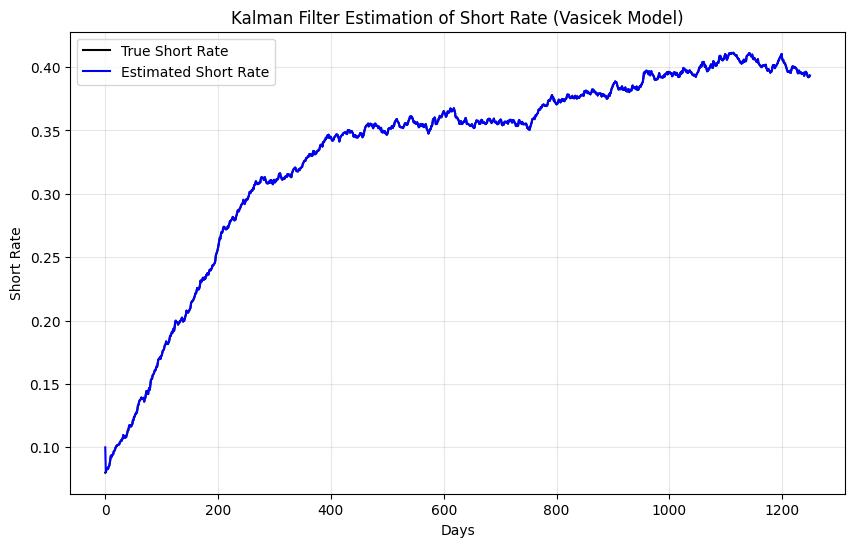

In [ ]:
#Set initial params for KF
r0_plus=0.1
p0=0.001
LL0=0

kappa = 1
theta = 0.4
sigma = 0.02
maturities = np.array([1, 2, 3, 4, 5,10,20]).reshape(-1, 1) # n_maturitiesx1 column vector
measurement_std = 1e-4  # Noise in yield measurements

# Apply Kalman filter
estimated_rates, estimated_variances,LL = simple_vasicek_kalman_filter(
  noisy_yields, maturities, kappa, theta, sigma, r0_plus,p0,measurement_std,LL0
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_rates, 'k-', label='True Short Rate')
plt.plot(estimated_rates, 'b-', label='Estimated Short Rate')
plt.title('Kalman Filter Estimation of Short Rate (Vasicek Model)')
plt.xlabel('Days')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



# **Use KF to recover vasicek params with NLL and replot KF rt**

In [ ]:
def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, r0, p0,LL0):
    kappa, theta, sigma,measurement_std = params
    _, _, log_likelihood = simple_vasicek_kalman_filter(
        yields, maturities, kappa, theta, sigma, r0, p0, measurement_std,LL0
    )
    return -log_likelihood  # We minimize, so take negative

Estimated kappa: 1.000110 (True: 1)
Estimated theta: 0.399795 (True: 0.4)
Estimated sigma: 0.001978 (True: 0.02)
Estimated noise: 0.000100 (True: 0.0001)


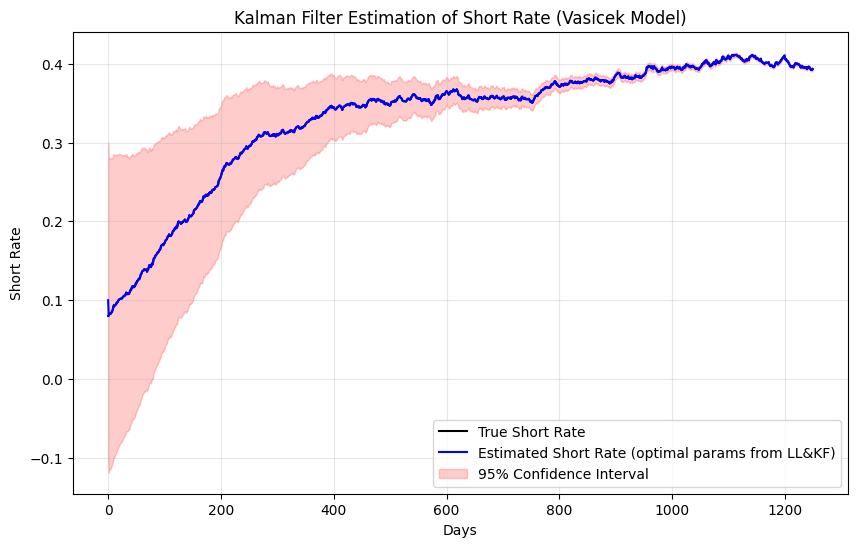

In [ ]:
#Set initial params for KF
r0_plus=0.1
p0=0.01
LL0=0

kappa = 1.5
theta = 0.2
sigma = 0.03
measurement_std = 0.001  # Noise in yield measurements

maturities = np.array([1, 2, 3, 4, 5,10,20])  # Maturities in years

initial_guess = [kappa, theta, sigma, measurement_std]
bounds = [(1e-3, 2),     # kappa
          (0.0, 0.7),    # theta
          (1e-3, 0.1),   # sigma
          (1e-5, 1e-3)]  # measurement_std – don’t let this go too close to 0

result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(noisy_yields, maturities, r0_plus, p0,LL0),
    bounds=bounds,
    method='L-BFGS-B'
)

#data generation paramters i.e. true parameters
true_kappa = 1
true_theta = 0.4
true_sigma = 0.02
true_measurement_std = 1e-4  # Noise in yield measurements

# Extract estimated parameters
estimated_kappa, estimated_theta, estimated_sigma,estimated_noise = result.x
print(f"Estimated kappa: {estimated_kappa:.6f} (True: {true_kappa})")
print(f"Estimated theta: {estimated_theta:.6f} (True: {true_theta})")
print(f"Estimated sigma: {estimated_sigma:.6f} (True: {true_sigma})")
print(f"Estimated noise: {estimated_noise:.6f} (True: {true_measurement_std})")

# Apply Kalman filter
estimated_rates_opt, estimated_variances_opt,LL_opt= simple_vasicek_kalman_filter(
  noisy_yields, maturities,estimated_kappa, estimated_theta, estimated_sigma, r0_plus,p0,estimated_noise,LL0
)
# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances_opt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_rates, 'k-', label='True Short Rate')
plt.plot(estimated_rates_opt, 'b-', label='Estimated Short Rate (optimal params from LL&KF)')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    np.arange(n_steps),
    estimated_rates_opt - 2 * std_dev,
    estimated_rates_opt + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Kalman Filter Estimation of Short Rate (Vasicek Model)')
plt.xlabel('Days')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **Compare KF implied yields to real Yields for each maturity**

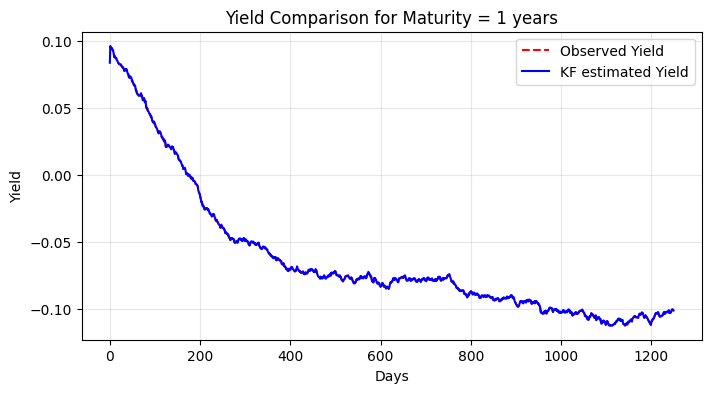

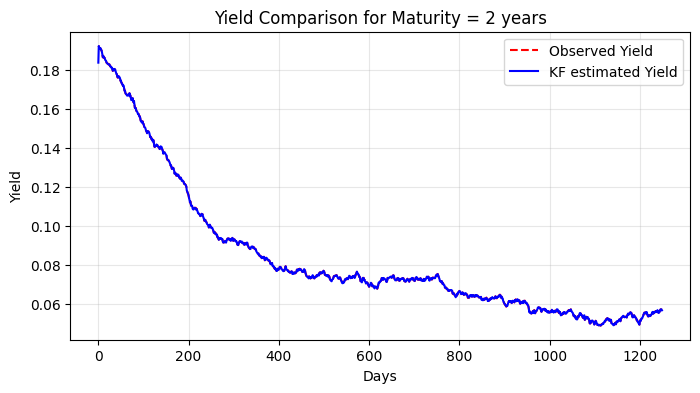

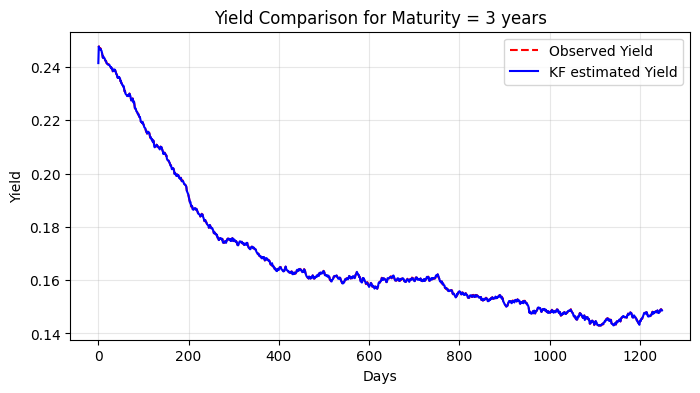

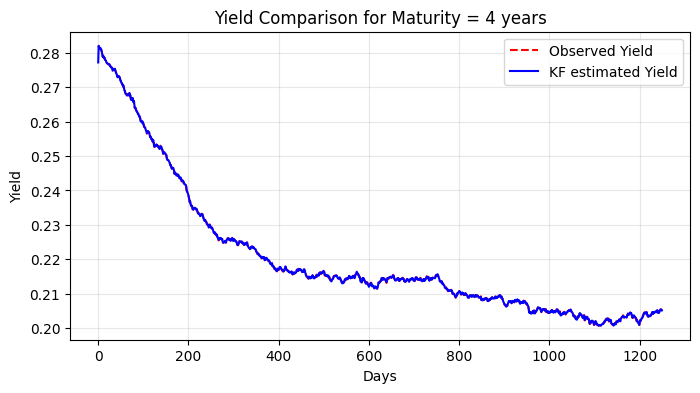

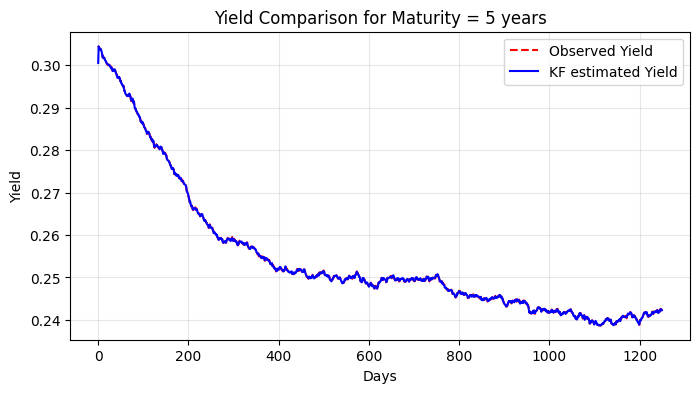

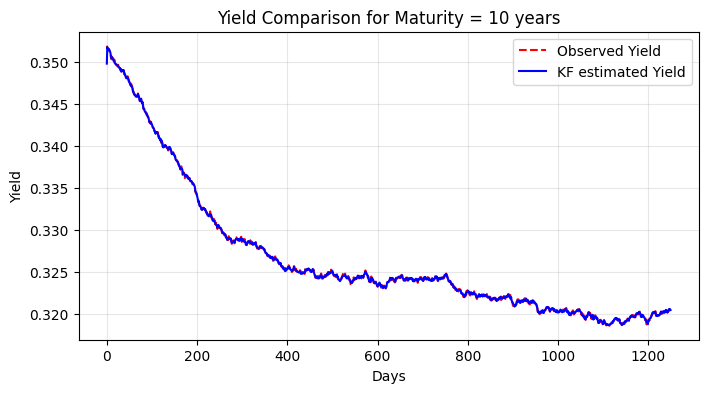

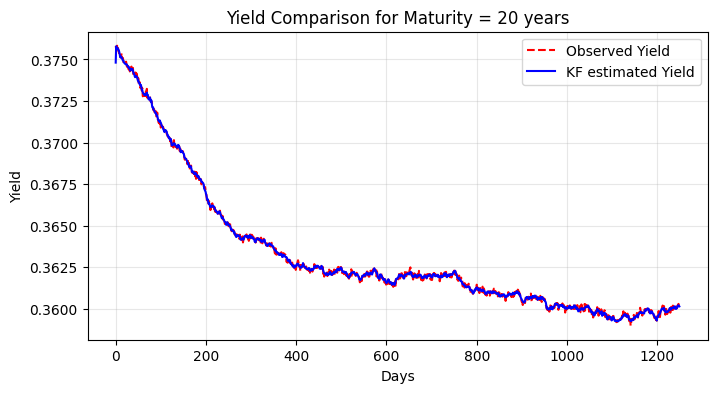

In [ ]:
def vasicek_yield_curve(r_t, kappa, theta, sigma, maturities):
    B_tau = (1 - np.exp(-kappa * maturities)) / kappa
    A_tau = (B_tau - maturities) * (theta - sigma**2 / (2 * kappa**2)) - \
            (sigma**2 * B_tau**2) / (4 * kappa)

    A_over_tau = A_tau / maturities
    B_over_tau = B_tau / maturities

    n_steps = len(r_t)
    n_maturities = len(maturities)
    KF_yields = np.zeros((n_steps, n_maturities))

    for t in range(n_steps):
        for j in range(n_maturities):
            KF_yields[t, j] = -A_over_tau[j] - B_over_tau[j] * r_t[t]

    return KF_yields


KF_yields = vasicek_yield_curve(
    estimated_rates_opt, estimated_kappa, estimated_theta, estimated_sigma, maturities
)

for i in range(len(maturities)):
    plt.figure(figsize=(8, 4))
    plt.plot(noisy_yields[i], 'r--', label='Observed Yield')
    plt.plot(KF_yields[:, i], 'b-', label='KF estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Days')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


